# Data processing of US airbnb data

Dataset: https://www.kaggle.com/datasets/kritikseth/us-airbnb-open-data

We study the price of US airbnb data in 2020. We clean the data (removing outliers, filling the missing values, etc.). We generate the new features such as generating the polynomials of numerical features.

In [1]:
import pandas as pd
import numpy as np
import string
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import HashingVectorizer
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('AB_US_2020.csv')

In [3]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,city
0,38585,Charming Victorian home - twin beds + breakfast,165529,Evelyne,NaN,28804,35.65146,-82.62792,Private room,60,1,138,16/02/20,1.14,1,0,Asheville
1,80905,French Chic Loft,427027,Celeste,NaN,28801,35.59779,-82.55540,Entire home/apt,470,1,114,07/09/20,1.03,11,288,Asheville
2,108061,Walk to stores/parks/downtown. Fenced yard/Pet...,320564,Lisa,NaN,28801,35.60670,-82.55563,Entire home/apt,75,30,89,30/11/19,0.81,2,298,Asheville
3,155305,Cottage! BonPaul + Sharky's Hostel,746673,BonPaul,NaN,28806,35.57864,-82.59578,Entire home/apt,90,1,267,22/09/20,2.39,5,0,Asheville
4,160594,Historic Grove Park,769252,Elizabeth,NaN,28801,35.61442,-82.54127,Private room,125,30,58,19/10/15,0.52,1,0,Asheville


In [4]:
df = df.drop(['id','host_id'], axis=1)

We set 'host_name' as categorical feature. We classify this feature with a single host and more than one hosts

In [5]:
index = df[df.host_name.fillna(' ').str.contains('&')].index
df['host'] = '1'
df['host'].iloc[index] = '0'
df = df.drop(['host_name'], axis=1)

Set 'latiture' and 'longitude' as polar coordinates

In [6]:
df['x'] = df['latitude'].apply(lambda x: np.cos(x)) * df['longitude'].apply(lambda x: np.cos(x))
df['y'] = df['latitude'].apply(lambda x: np.cos(x)) * df['longitude'].apply(lambda x: np.sin(x))
df['z'] = df['longitude'].apply(lambda x: np.sin(x))
df = df.drop(['latitude','longitude'], axis=1)

Set duration for period between the date of last review and the last date '2020-12-30'

In [7]:
df.last_review = pd.to_datetime(df.last_review)
min_time = pd.to_datetime(df.last_review.dropna(), format='%Y-%m-%d').min()
df['maxdate'] = pd.to_datetime('2020-12-30')
df['duration'] = df['maxdate'] - df.last_review
df['duration'] = df['duration'].dt.total_seconds()/(24 * 60 * 60)
mean_duration = df['duration'].mean()
df['duration'] = df['duration'].fillna(mean_duration)

df = df.drop(['last_review'], axis=1)
df = df.drop(['maxdate'], axis=1)

# Numerical features

In [8]:
num_feature = ['duration','minimum_nights','number_of_reviews','reviews_per_month','calculated_host_listings_count','availability_365','x','y','z']

In [9]:
for x in num_feature:
    df[x] = df[x].fillna(df[x].mean())

Remove outliers for the upper percentile larger than 98% and the lower percentile smaller than 2%

In [10]:
for feature in num_feature:
    upper = np.percentile(df[feature], 98)
    lower = np.percentile(df[feature], 2)
    df = df[df[feature]<upper]
    df = df[df[feature]>lower]

In [11]:
df[num_feature].describe()

,duration,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,x,y,z
count,39324.000000,39324.000000,39324.000000,39324.000000,39324.000000,39324.000000,39324.000000,39324.000000,39324.000000
mean,309.943622,9.947386,32.157461,1.137938,15.769733,211.227266,-0.208242,-0.180170,0.300156
std,211.327009,11.679706,40.471179,1.054049,24.983107,116.189328,0.346219,0.523568,0.741387
min,55.000000,2.000000,1.000000,0.040000,2.000000,1.000000,-0.992500,-0.992599,-0.997605
25%,161.000000,2.000000,4.000000,0.290000,2.000000,91.000000,-0.455731,-0.699108,-0.593323
50%,282.000000,3.000000,15.000000,0.790000,5.000000,224.000000,-0.154051,-0.106040,0.778173
75%,363.000000,20.000000,44.000000,1.720000,16.000000,326.000000,0.005245,0.172574,0.930770
max,1665.000000,40.000000,210.000000,4.560000,133.000000,364.000000,0.849332,0.695163,0.999961


# Correlation

In [12]:
df[num_feature].corr()

,duration,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,x,y,z
duration,1.000000,0.154238,-0.211734,-0.390055,0.021095,0.007456,0.011634,-0.020117,0.001216
minimum_nights,0.154238,1.000000,-0.095627,-0.193567,0.003410,0.024245,-0.201959,-0.288691,0.084078
number_of_reviews,-0.211734,-0.095627,1.000000,0.692051,-0.187375,-0.009208,-0.016804,-0.020043,-0.009389
reviews_per_month,-0.390055,-0.193567,0.692051,1.000000,-0.168004,-0.095281,0.004345,0.004827,-0.000258
calculated_host_listings_count,0.021095,0.003410,-0.187375,-0.168004,1.000000,0.093220,0.074290,0.104236,-0.062991
availability_365,0.007456,0.024245,-0.009208,-0.095281,0.093220,1.000000,-0.005401,0.015710,0.049246
x,0.011634,-0.201959,-0.016804,0.004345,0.074290,-0.005401,1.000000,0.370746,-0.013218
y,-0.020117,-0.288691,-0.020043,0.004827,0.104236,0.015710,0.370746,1.000000,-0.403639
z,0.001216,0.084078,-0.009389,-0.000258,-0.062991,0.049246,-0.013218,-0.403639,1.000000


Since the 'review_per_month' is highly correlated with 'number_of_reviews', we keep 'number_of_reviews' only.

In [13]:
df = df.drop(['reviews_per_month'], axis=1)

In [14]:
num_feature.remove('reviews_per_month')

# Pairplot

Ref: https://stackoverflow.com/questions/65345377/proper-diagonal-y-axes-for-seaborn-pairplot

In [15]:
def hist_plot(x, label, color):
    ax0 = plt.gca()
    ax = ax0.twinx()
    
    sns.despine(ax=ax, left=True, top=True, right=False)
    ax.yaxis.tick_right()
    ax.set_ylabel('Counts')
    
    ax.hist(x, label=label, color=color, bins=100)

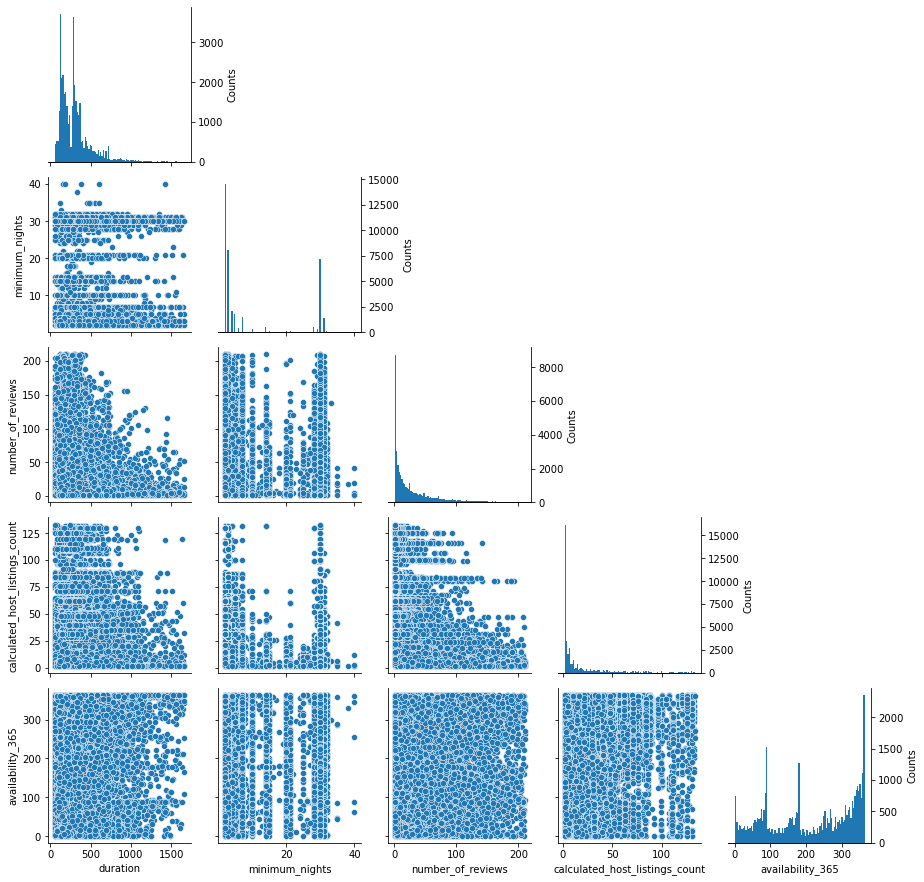

In [16]:
splot = sns.PairGrid(df[['duration','minimum_nights','number_of_reviews','calculated_host_listings_count','availability_365']],corner=True)
splot.map_diag(hist_plot)
splot.map_lower(sns.scatterplot)

Some numerical features show the multi-modal distributions.

Generate interaction terms 

In [17]:
transform_feature = []
for i in range(0, len(num_feature)-1):
    for j in range(i+1, len(num_feature)):
        feature1 = num_feature[i]
        feature2 = num_feature[j]
        feature = feature1 + ' * ' + feature2
        df[feature] = df[feature1] * df[feature2]
        transform_feature.append(feature)

Transform the numerical features with squared, cubed and log

In [18]:
for i in num_feature:
    df[i+'_squared'] = df[i].pow(2)
    df[i+'_cubed'] = df[i].pow(3)
    df[i+'_log'] = np.log1p(df[i].abs())
    transform_feature.append(i+'_squared')
    transform_feature.append(i+'_cubed')
    transform_feature.append(i+'_log')

# Transform the categorical features with one-hot encoding

In [19]:
cat_feature = ['host','neighbourhood_group', 'room_type', 'city']
new_cat = []
for x in cat_feature:
    temp = pd.get_dummies(df[x].fillna(x+'_NULL'), prefix=x, drop_first=True)
    df = pd.concat([df,temp], axis=1)
    new_cat += list(temp.columns)
df = df.drop(cat_feature, axis=1)

Clean the text features: name, neighbourhood

In [20]:
punctuation = string.punctuation+'»«“”’'
stop_words = stopwords.words('english')
words = nltk.corpus.words.words()

In [21]:
def clean_doc(data):
    data = data.str.lower() # change to lower capital
    data =  data.str.replace('’s',' ')
    data = data.str.replace(r'[\d|\n]',' ') # remove digits
    data = data.str.replace('[{}]'.format(punctuation), ' ') # remove punctuation
    data = data.str.split()
    data = data.fillna(' ') # fill 'nan' with ' '
    data = data.apply(lambda x: [y for y in x if y in words and y not in stop_words])
    data = data.apply(lambda x: ' '.join(x))
    data = data.fillna(' ') # fill 'nan' with ' '
    return data

In [22]:
df.name = clean_doc(df.name)

In [23]:
df.neighbourhood = df.neighbourhood.str.replace('[{}]'.format(punctuation), ' ')

Split the data into train, test and valiation

In [24]:
feature = list(df.columns)
feature.remove('price')

X = df[feature]
y = df['price']

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=21)
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, test_size=0.1, random_state=21)

Scale the features with MinMaxScaler 

In [25]:
def transform_func(data, feature, transform, mode=0):
    if mode == 0:
        temp = transform.fit_transform(data[feature])
    elif mode == 1:
        temp = transform.transform(data[feature])
    transformed_data = pd.DataFrame(temp)
    transformed_data.columns = feature
    transformed_data.index = data.index
    return transformed_data, transform

In [26]:
num_feature = num_feature + transform_feature

In [27]:
scaler = MinMaxScaler(feature_range=(0, 1))

train_X_std, scaler = transform_func(train_X, num_feature, scaler, 0)
val_X_std, _ = transform_func(val_X, num_feature, scaler, 1)
test_X_std, _ = transform_func(test_X, num_feature, scaler, 1)

# Vectorize the text features using HashingVectorizer

In [28]:
def vectorize_func(data, vectorizer, col_name, mode=0):
    if mode == 0:
        vector = vectorizer.fit_transform(data)
    elif mode == 1:
        vector = vectorizer.transform(data)
    temp = pd.DataFrame(vector.toarray())
    column = [col_name+str(x) for x in range(0,len(temp.columns))]
    temp.columns = column
    temp.index = data.index
    return temp

In [29]:
vectorizer = HashingVectorizer(n_features=100)
name_vect = vectorizer.fit_transform(train_X.name.fillna(' '))

temp = vectorize_func(train_X.name.fillna(' '), vectorizer, 'hashname_', 0)
train_X = pd.concat([train_X,temp], axis=1)
train_X = train_X.drop(['name'],axis=1)
new_cat += list(temp.columns)

temp = vectorize_func(val_X.name.fillna(' '), vectorizer, 'hashname_', 1)
val_X = pd.concat([val_X,temp], axis=1)
val_X = val_X.drop(['name'],axis=1)

temp = vectorize_func(test_X.name.fillna(' '), vectorizer, 'hashname_', 1)
test_X = pd.concat([test_X,temp], axis=1)
test_X = test_X.drop(['name'],axis=1)

In [30]:
vectorizer = HashingVectorizer(n_features=10)
name_vect = vectorizer.fit_transform(train_X.neighbourhood.fillna(' '))

temp = vectorize_func(train_X.neighbourhood.fillna(' '), vectorizer, 'hashneigh_', 0)
train_X = pd.concat([train_X,temp], axis=1)
train_X = train_X.drop(['neighbourhood'],axis=1)
new_cat += list(temp.columns)

temp = vectorize_func(val_X.neighbourhood.fillna(' '), vectorizer, 'hashneigh_', 1)
val_X = pd.concat([val_X,temp], axis=1)
val_X = val_X.drop(['neighbourhood'],axis=1)

temp = vectorize_func(test_X.neighbourhood.fillna(' '), vectorizer, 'hashneigh_', 1)
test_X = pd.concat([test_X,temp], axis=1)
test_X = test_X.drop(['neighbourhood'],axis=1)

In [31]:
train_X_std = pd.concat([train_X_std, train_X[new_cat]], axis=1)
test_X_std = pd.concat([test_X_std, test_X[new_cat]], axis=1)
val_X_std = pd.concat([val_X_std, val_X[new_cat]], axis=1)

In [32]:
train_X_std.to_csv('train_X.csv')
test_X_std.to_csv('test_X.csv')
val_X_std.to_csv('val_X.csv')
train_y.to_csv('train_y.csv')
test_y.to_csv('test_y.csv')
val_y.to_csv('val_y.csv')